In [7]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

# Set parameters
DATA_DIR = "PlantVillage"  # This folder has subfolders for each class
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 16
SEED = 123

# Load the full dataset from directory without split
full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)

# Get number of batches
total_batches = tf.data.experimental.cardinality(full_ds).numpy()
print(f"Total batches: {total_batches}")

# Define split sizes
train_size = int(total_batches * 0.7)  # 70% for train
val_size = int(total_batches * 0.15)   # 15% for val
test_size = total_batches - train_size - val_size  # remaining 15% for test

# Split the dataset
train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Save class names for later use (e.g., in inference)
class_names = full_ds.class_names
np.save("class_names.npy", class_names)

print("Class names:", class_names)
print(f"Train batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

Found 16011 files belonging to 10 classes.
Total batches: 1001
Class names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Train batches: 700
Validation batches: 150
Test batches: 151


In [8]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess(img, label):
    img = tf.cast(img, tf.float32)
    return preprocess_input(img), label

train_ds = train_ds.map(preprocess).prefetch(AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(AUTOTUNE)

In [9]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(160, 160, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # fine-tune later

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

In [10]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
700/700 [==============================] - 304s 428ms/step - loss: 0.7466 - accuracy: 0.7519 - val_loss: 0.3887 - val_accuracy: 0.8721
Epoch 2/10
700/700 [==============================] - 221s 315ms/step - loss: 0.3954 - accuracy: 0.8652 - val_loss: 0.2782 - val_accuracy: 0.9112
Epoch 3/10
700/700 [==============================] - 196s 280ms/step - loss: 0.3358 - accuracy: 0.8859 - val_loss: 0.2694 - val_accuracy: 0.9158
Epoch 4/10
700/700 [==============================] - 191s 272ms/step - loss: 0.2937 - accuracy: 0.9002 - val_loss: 0.2982 - val_accuracy: 0.9029
Epoch 5/10
700/700 [==============================] - 186s 265ms/step - loss: 0.2737 - accuracy: 0.9054 - val_loss: 0.2657 - val_accuracy: 0.9167
Epoch 6/10
700/700 [==============================] - 192s 274ms/step - loss: 0.2604 - accuracy: 0.9087 - val_loss: 0.2230 - val_accuracy: 0.9275
Epoch 7/10
700/700 [==============================] - 231s 330ms/step - loss: 0.2452 - accuracy: 0.9161 - val_loss: 0.2269 -

In [11]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


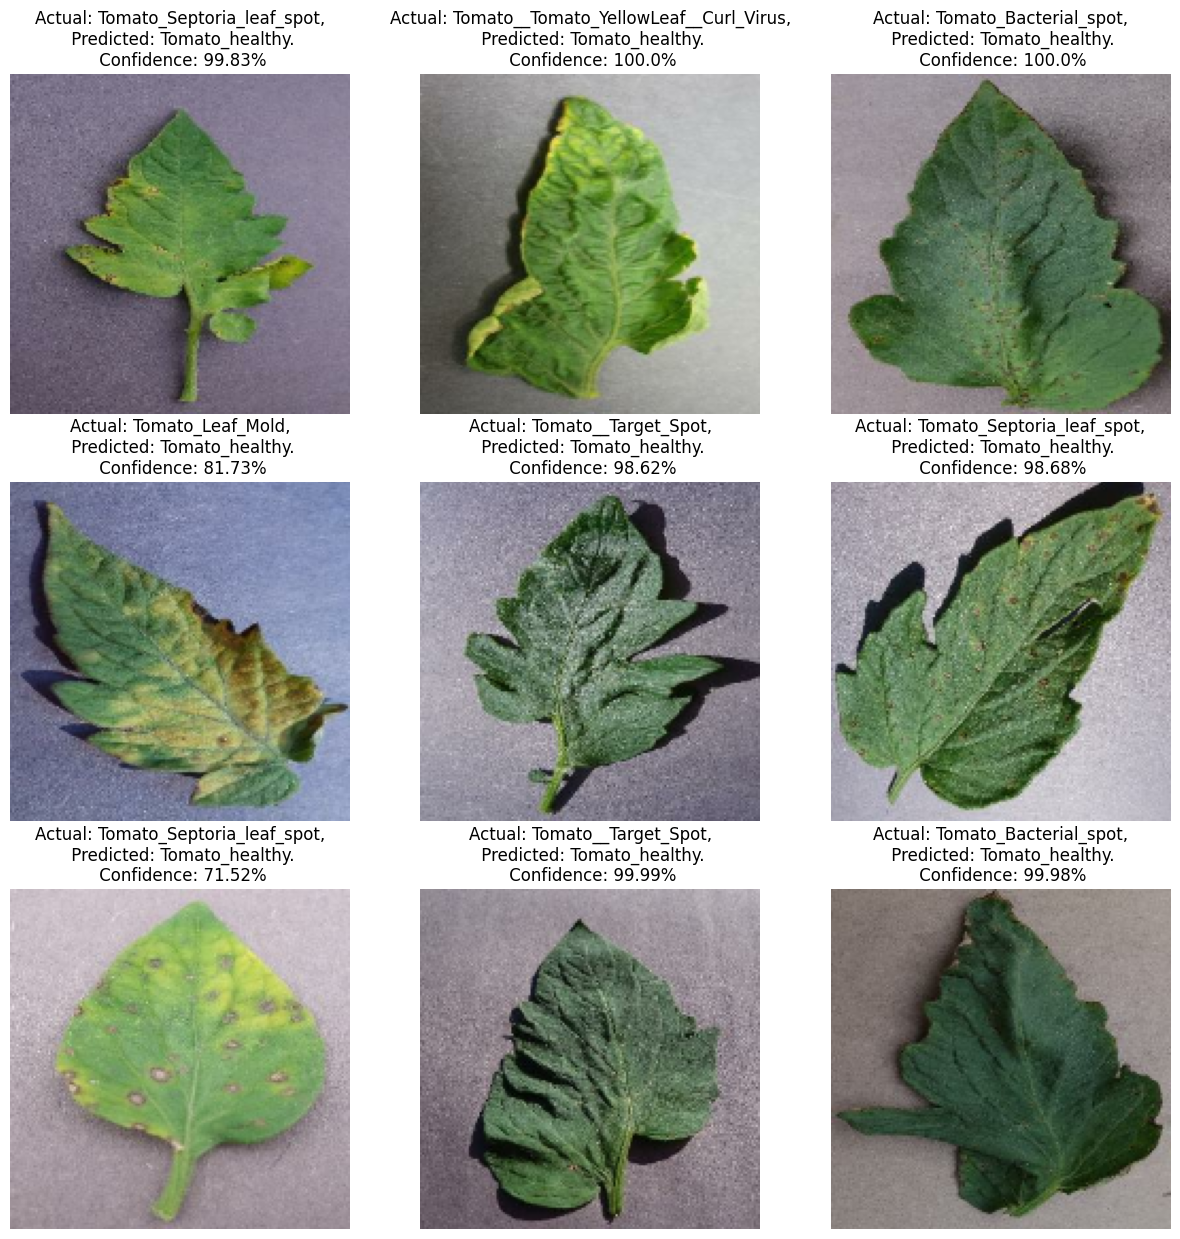

In [12]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [14]:
# model.save(f"../saved_models/clean_model")

In [15]:
model.save(f"../saved_models/clean_model.h5")